Rethinking Chp2.3: Grid Approximation

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

# aliases
tfd = tfp.distributions

In [ ]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [ ]:
n_points = 20
p_grid = tf.linspace(start=0., stop=1., num=n_points)
prior = tf.ones([n_points])

num_trials = tf.constant([1, 2, 3, 4, 5, 6, 7, 8, 9])

# 0-padded to support the cumulative sum with len(num_trials)
globe_toss_data = tf.constant([0, 1, 0, 1, 1, 1, 0, 1, 0, 1], dtype=tf.float32)
cumulative_water_counts = tf.gather(tf.cumsum(globe_toss_data), num_trials)

In [ ]:
prior = tf.repeat(1., 20)

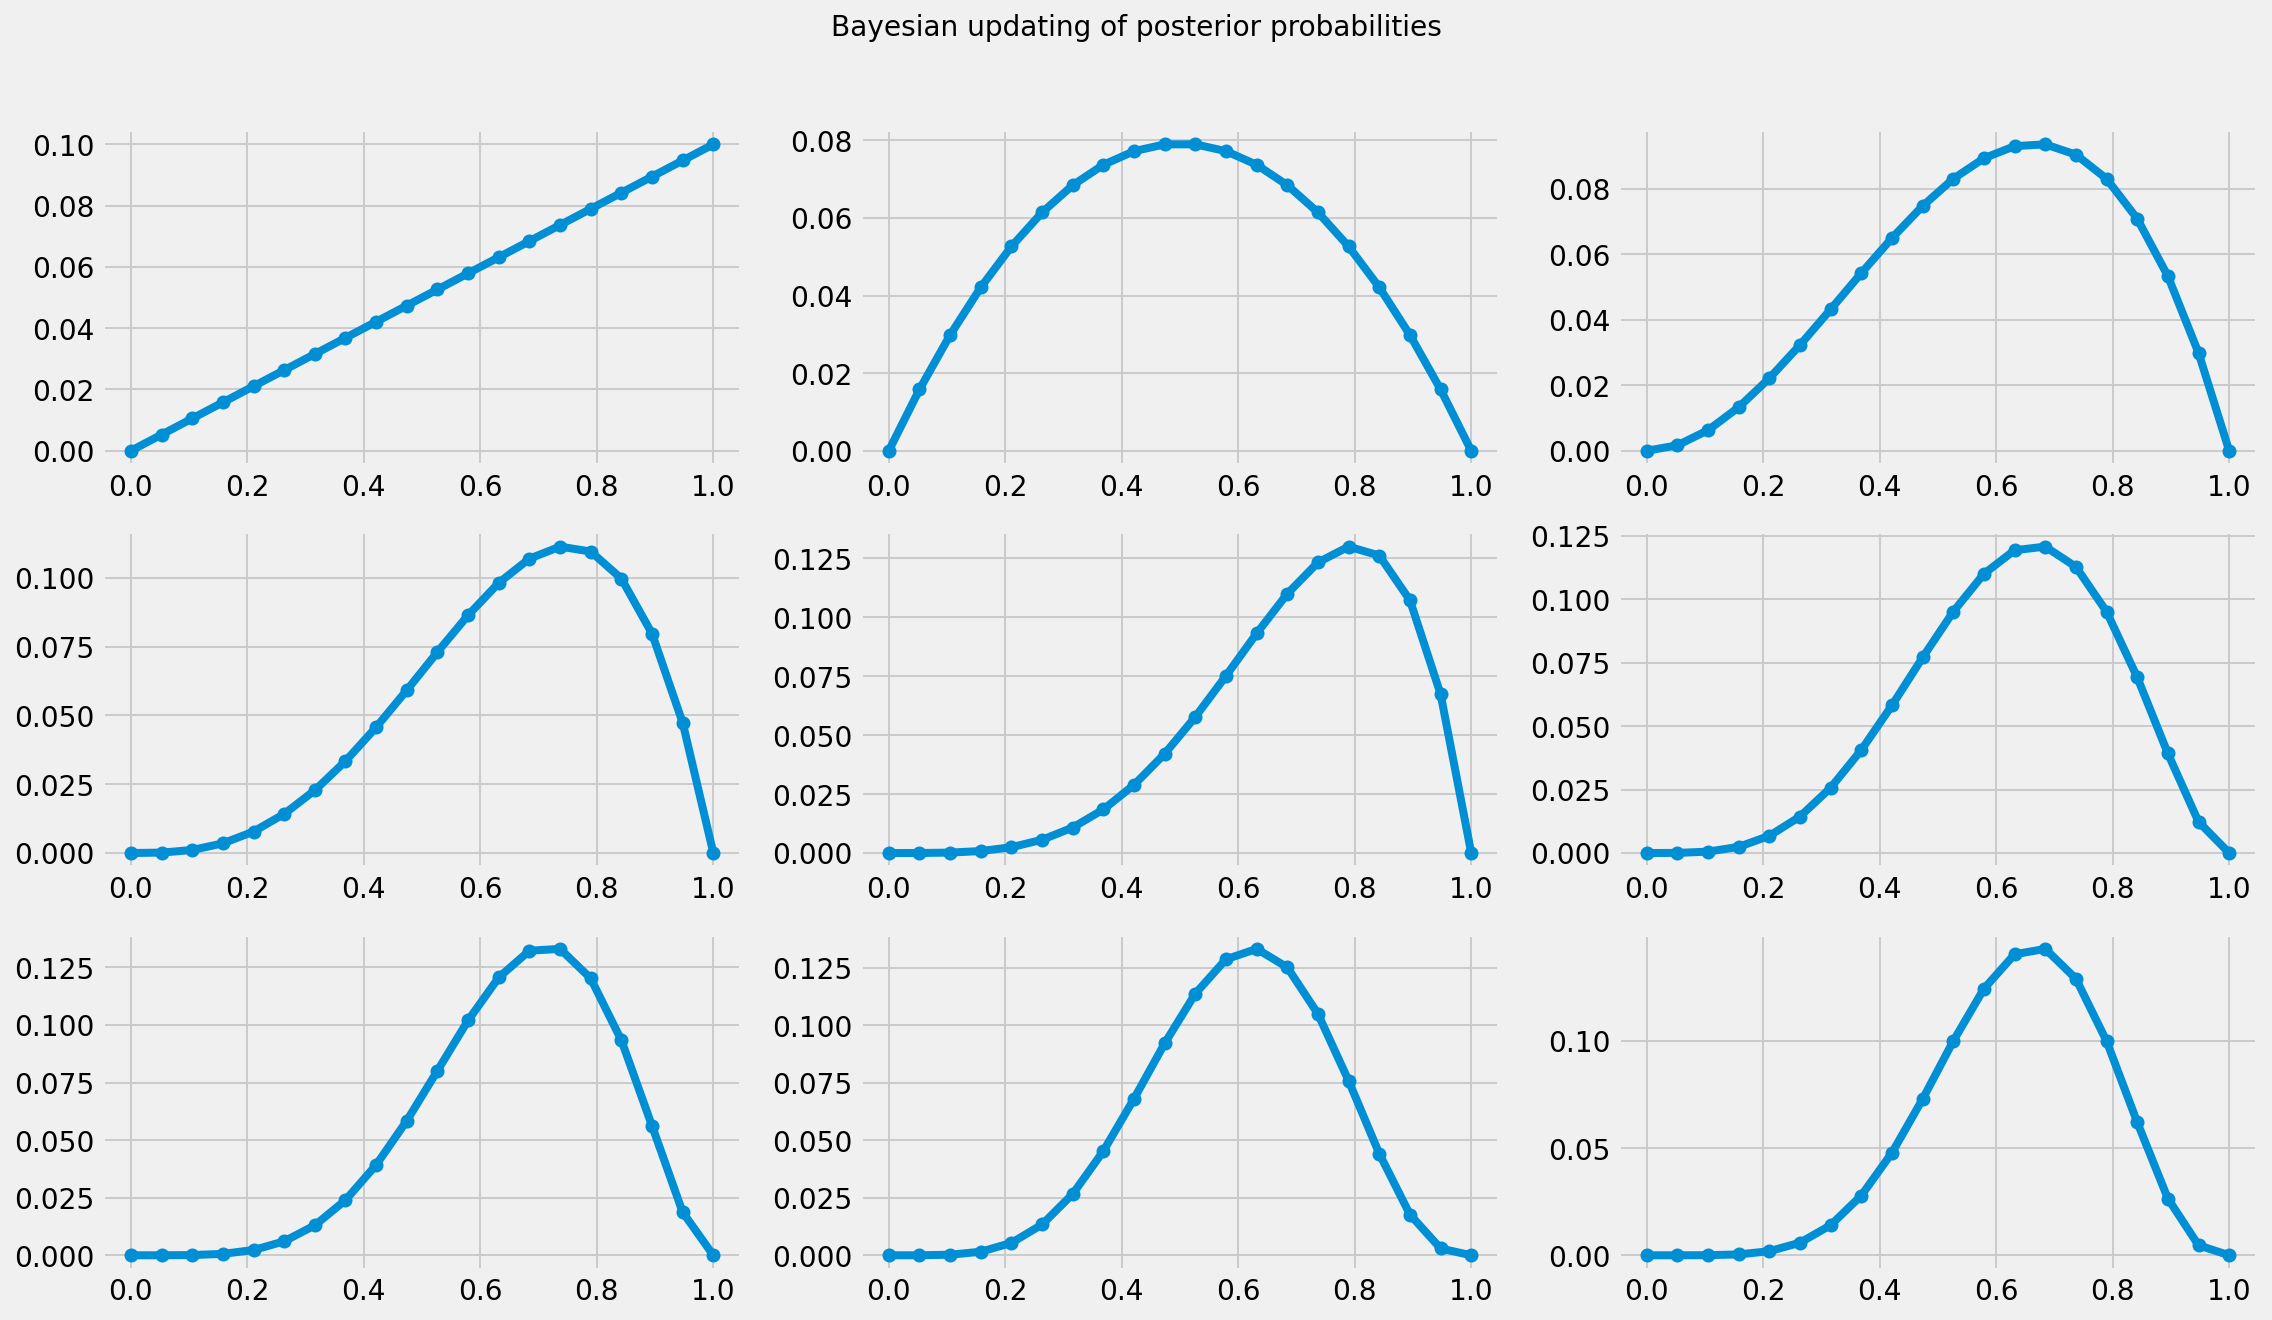

In [ ]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from IPython.core.pylabtools import figsize

plt.figure(figsize(16, 9))
likelihood = None
for i in range(len(num_trials)):
    likelihood = tfp.distributions.Binomial(tf.cast(num_trials[i],tf.float32), probs=p_grid).prob(cumulative_water_counts[i])
    posterior = prior * likelihood
    posterior = posterior / tf.reduce_sum(posterior)
    sx = plt.subplot(int(len(num_trials)/3), 3, i+1)
    #plt.xlabel("$p$, probability of W") \
    #if i in [0, len(num_trials)-1] else None
    #plt.setp(sx.get_yticklabels(), visible=False)
    plt.plot(p_grid, posterior, "-o")
    # plt.fill_between(probs_of_heads, 0, observed_probs_heads[i],
    #                  color=TFColor[3], alpha=0.4)
    # plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)
    # leg = plt.legend()
    # leg.get_frame().set_alpha(0.4)
    # plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities", y=1.02,
             fontsize=14)
plt.tight_layout()
plt.show()

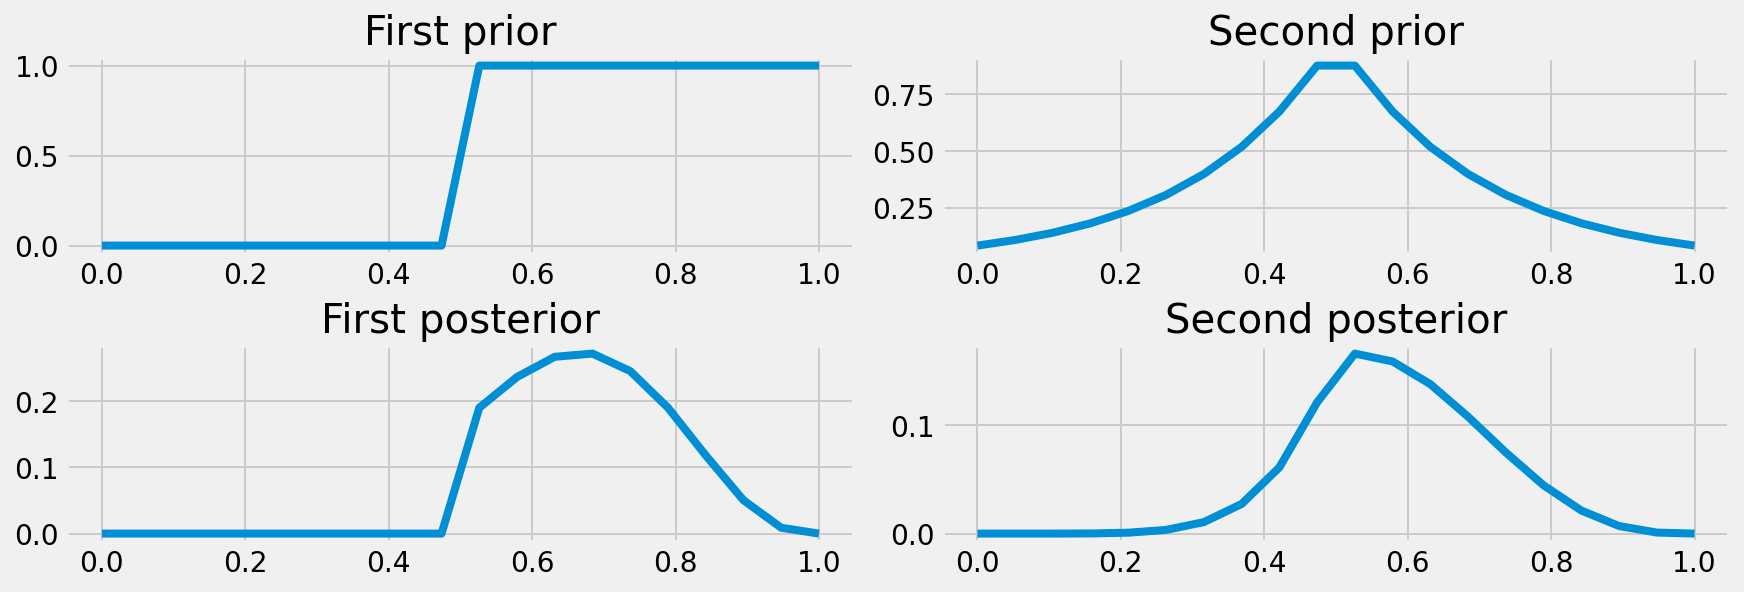

In [ ]:
first_prior = tf.where(condition=p_grid < 0.5, x=0., y=1)
second_prior = tf.exp(-5 * abs(p_grid - 0.5))

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4),
                       constrained_layout=True)

axes[0, 0].plot(p_grid, first_prior)
axes[0, 0].set_title('First prior')
axes[1, 0].plot(p_grid, first_prior * likelihood)
axes[1, 0].set_title('First posterior')

axes[0, 1].plot(p_grid, second_prior)
axes[0, 1].set_title('Second prior')
axes[1, 1].plot(p_grid, second_prior * likelihood)
axes[1, 1].set_title('Second posterior');


Quadratic Approximation: TFP doesn't natively provide a quap function, like in the book. But it has a lot of optimization tools. We'll use bfgs, which gives us a somewhat straightforward way to get both the measurement and the standard error.


In [ ]:
W = 6
L = 3
dist = tfd.JointDistributionNamed({
    "probability": tfd.Uniform(low=0., high=1.),
    "water": lambda probability: tfd.Binomial(total_count=W + L,
                                              probs=probability)
})

def neg_log_prob(x):
    return tfp.math.value_and_gradient(
          lambda p: -dist.log_prob(
              probability=tf.clip_by_value(p[-1], 0., 1.),
              water=W),
          x,
    )

results = tfp.optimizer.bfgs_minimize(neg_log_prob, initial_position=[0.5])
assert results.converged


In [ ]:
approximate_posterior = tfd.Normal(
    results.position,
    tf.sqrt(results.inverse_hessian_estimate),
)

print(
    "mean:", approximate_posterior.mean(),
    "\nstandard deviation: ", approximate_posterior.stddev(),
)


mean: tf.Tensor([[0.6666667]], shape=(1, 1), dtype=float32) 
standard deviation:  tf.Tensor([[0.14433755]], shape=(1, 1), dtype=float32)


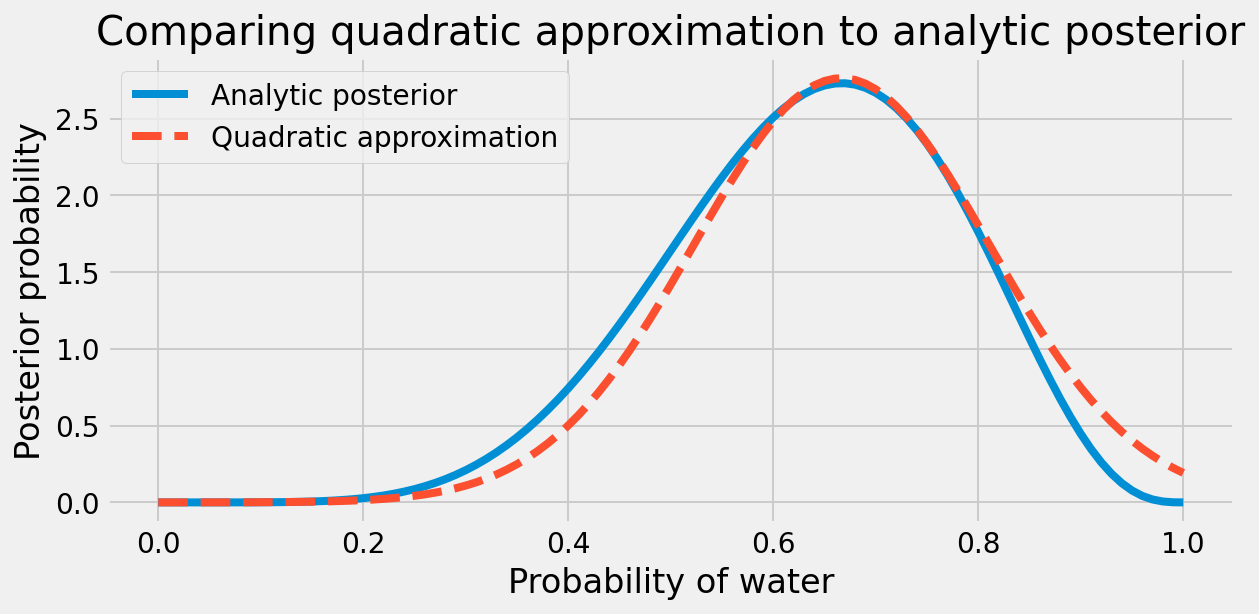

In [ ]:
_, ax = plt.subplots(figsize=(9, 4))

x = tf.linspace(0., 1., num=101)
ax.plot(x, tfd.Beta(W + 1, L + 1).prob(x), label='Analytic posterior')
# values obained from quadratic approximation
ax.plot(x, tf.squeeze(approximate_posterior.prob(x)), "--",
         label='Quadratic approximation')

ax.set(
    xlabel='Probability of water',
    ylabel='Posterior probability',
    title='Comparing quadratic approximation to analytic posterior'
)
ax.legend();